## Preprocessing of paired MRI-PET data in Python
This script demonstrates the utility of functions implemented to work with paired MRI-PET data. In order to preserve atrophy patterns, MRI data was not spatially normalized. PET and region-of-interest data are normalized to MRI for spatial correspondence. Importantly, preprocessing is entirely based on Python, i.e., independent of closed-source preprocessing tools.

In [1]:
import preprocessing_utils

import os
import ants
import tqdm
import glob
import shutil
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

warnings.filterwarnings("ignore")

### Get all regions of interest

In [2]:
mni_template = ants.image_read("../templates/TPM_GM.nii")
mni_atlas = "../templates/MNI_combined_atlas.nii"
inf_cereb = "../templates/MNI_inferior_cerebellum.nii"
cereb = "../templates/MNI_Logical_Cerebellum.nii"

tau_roi = "../templates/MNI_Tau_Jackmeta.nii"
amy_roi = "../templates/MNI_AV45_mask.nii"

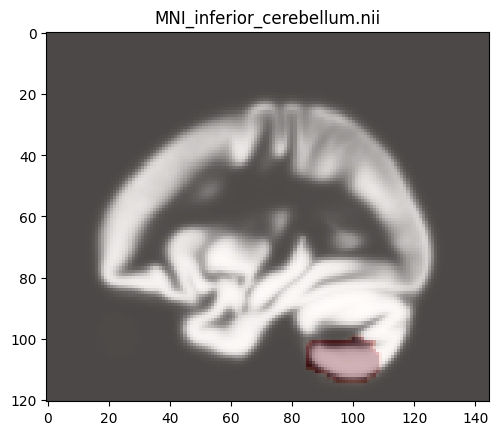

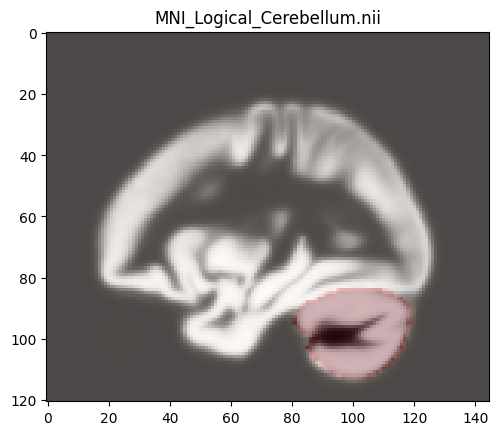

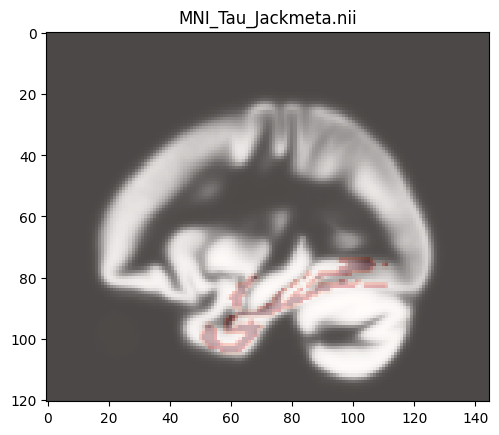

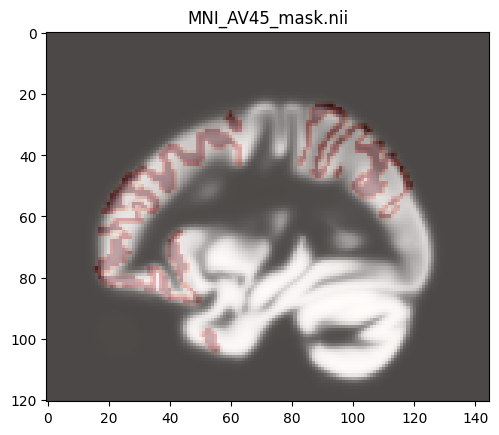

In [5]:
# show all ROIs
rois = [inf_cereb, cereb, tau_roi, amy_roi]  # mni_atlas approval for sharing is pending

for r in rois:
    name = r.split("/")[-1]
    r_ants = ants.image_read(r)
    plt.imshow(np.fliplr(np.rot90(mni_template.numpy()[40, :, :])),
              cmap="Greys_r")
    plt.imshow(np.fliplr(np.rot90(r_ants.numpy()[40, :, :])),
              cmap="Reds", alpha=0.3)
    plt.title(name)
    plt.show()

### Preprocess raw data
For MRI-to-PET scan correspondence, a dataframe (df) was created that maps each subject's MRI scan to a timely-acquired PET scan. The project that these utilities were implemented for used paired MRI-Amyloid PET and MRI-Tau PET data.

In [ ]:
# config
smoothing = 8
modality = "Tau"
directory = f"../data/MRI-to-{modality}/"
df = pd.read_csv(f"../data/TABLES/merge_results/MRI_{modality.upper()}_90 days_QC.csv")
mri_image_ids = df['Image Data ID_MRI'].values.flatten()
pet_image_ids = df[f'Image Data ID_{modality.upper()}'].values.flatten()

# Choose ROIs and reference regions for SUVr computation based on PET modality
roi = tau_roi if modality == "Tau" else amy_roi
reference = inf_cereb if modality == "Tau" else cereb
rois = [roi, mni_atlas, reference]
roi_names = ["ROI", "composite_atlas", "SUVR_reference"]
plot_idx = 70 if modality == "Tau" else 55

# Initiate PDF for efficient quality control
with PdfPages('../results/QC2.pdf') as pdf:
    for i in tqdm.tqdm(range(len(mri_image_ids))):
        # Create temporary directory for ANTs tmp files
        os.makedirs(f"./rmdir2/")
        
        # Get ID and paired data of current subject
        subject_id = df.loc[df['Image Data ID_MRI'] == mri_image_ids[i], ['Subject']]
        mri_tmp = glob.glob(f"{directory}/MRI/1_Nifti/*{mri_image_ids[i]}*/I*.nii")
        pet_tmp = glob.glob(f"{directory}/{modality}/1_Nifti/*{pet_image_ids[i]}*/s*.nii")

        # Ensure both an MRI scan and a PET scan are available
        if not ((len(mri_tmp)>0) and (len(pet_tmp)>0)):
            print(f"Scan pair not complete for {mri_image_ids[i]}")
            continue
        
        # Get location where PET scan is stored
        path_tmp = os.path.dirname(pet_tmp[0])
        
        # Preprocess MRI
        params_tmp = preprocessing_utils.preprocess_mri(mri_tmp[0])
        # Preprocess PET, if registration between PET and MRI fails, don't break 
        # This is sometimes necessary, as ANTs (main library used here) was
        # optimized only for MRI
        try:
            masked_pet = preprocessing_utils.preprocess_pet(pet=pet_tmp[0],
                                                            mri_unmasked=params_tmp['mri_unmasked'],
                                                            smoothing=smoothing,
                                                            mask=params_tmp['mask']
                                                           )
        except:
            print(f"Skipping {mri_image_ids[i]} as registration failed.")
            continue

        # Preprocess ROIs
        masked_rois = preprocessing_utils.preprocess_rois(rois,
                                                          roi_names,
                                                          mri=params_tmp['mri'],
                                                          folder=path_tmp,
                                                          mask=params_tmp['mask']
                                                         )
        
        # Compute SUVr maps and mean SUVr based on provided reference region
        suvr_img = preprocessing_utils.compute_suvr(masked_pet,
                                                    masked_rois['SUVR_reference'],
                                                    folder=path_tmp,
                                                    img_id=pet_image_ids[i],
                                                    smoothing=smoothing
                                                   )
        suvr = (suvr_img[masked_rois['ROI']>0]).mean()

        # Plot results in PDF
        fig, ax = plt.subplots(2, 2, figsize=(8,8))
        fig.subplots_adjust(bottom=0.15)
        ax[0,0].imshow(np.fliplr(np.rot90(params_tmp['mri'].numpy()[:, plot_idx, :])),
                      cmap="Greys_r")
        ax[0,0].imshow(np.fliplr(np.rot90(params_tmp['mask'].numpy()[:, plot_idx, :])),
                      cmap='Reds', alpha=0.7)
        ax[0,1].imshow(np.fliplr(np.rot90(masked_rois['composite_atlas'].numpy()[:, plot_idx, :])),
                      cmap='jet')
        ax[1,0].imshow(np.fliplr(np.rot90(params_tmp['mri'].numpy()[:, plot_idx, :])),
                      cmap="Greys_r")
        ax[1,0].imshow(np.fliplr(np.rot90(suvr_img.numpy()[:, plot_idx, :])),
                      cmap='jet', alpha=0.8, vmax=3.0)
        ax[1,1].imshow(np.fliplr(np.rot90(suvr_img.numpy()[:, plot_idx, :])),
                      cmap='jet', vmax=3.0)
        ax[1,1].imshow(np.fliplr(np.rot90(masked_rois['ROI'].numpy()[:, plot_idx, :])),
                      cmap='Reds', alpha=0.5)
        fig.text(0.5, 0.05, f"{subject_id} {mri_image_ids[i]} - SUVR: {suvr:.2f}", ha='center', fontsize=12)
        pdf.savefig(fig)
        plt.close()
        
        # Remove tmp files
        shutil.rmtree('./rmdir2/')